In [1]:
import torch
import torch_geometric_temporal
import json
import numpy as np
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# seed
np.random.seed(0)
torch.manual_seed(0)

In [3]:
# define the number of features
feature_num = 3

# DAILY
start_col = 1

# HOURLY
# start_col = 2

# define the number of time steps
time_step_in = 4
time_step_out = 1

In [4]:
# get station loc
station_loc = pd.read_csv('station_loc.csv')

station_loc.describe

<bound method NDFrame.describe of               station name  station id   latitude  longitude
0   اتوبان محلاتی منطقه ۱۴           1  51.464427  35.660147
1       ستاد بحران منطقه ۷           2  51.430829  35.727223
2                     پونک           3  51.331618  35.761750
3          پیروزی منطقه ۱۳           4  51.493530  35.695771
4        میدان فتح منطقه ۹           5  51.337724  35.678608
5            گلبرگ منطقه ۸           6  51.505596  35.730912
6         شهرداری منطقه ۲۲           7  51.243523  35.722596
7         شهرداری منطقه ۱۹           8  51.364311  35.621806
8       تربیت مدرس منطقه ۶           9  51.385910  35.717945
9          شهرداری منطقه ۲          10  51.367807  35.777269
10          اقدسیه منطقه ۱          11  51.485632  35.796761>

In [5]:
node_num = len(station_loc)

In [6]:
directory = 'Dataset/'

dataset = []

# read csv files in Dataset folder
for i in range(node_num):
    file_name = f'cleaned_data_{i}.csv'
    node = pd.read_csv(directory + file_name).iloc[:, start_col: start_col + feature_num].values
    dataset.append(node)
    print(file_name)

dataset = np.array(dataset)


cleaned_data_0.csv
cleaned_data_1.csv
cleaned_data_2.csv
cleaned_data_3.csv
cleaned_data_4.csv
cleaned_data_5.csv
cleaned_data_6.csv
cleaned_data_7.csv
cleaned_data_8.csv
cleaned_data_9.csv
cleaned_data_10.csv


In [7]:
dataset.shape

(11, 1095, 3)

In [8]:
# mean, max, average of features
d = dataset

print('CO', d[:, :, 0].mean(), d[:, :, 0].max(), d[:, :, 0].min())
print('SO2', d[:, :, 1].mean(), d[:, :, 1].max(), d[:, :, 1].min())
print('PM10', d[:, :, 2].mean(), d[:, :, 2].max(), d[:, :, 2].min())

CO 1.5835646155588556 7.02246525 0.16313125
SO2 5.963400870573127 58.03220945 0.30258259
PM10 81.40567118700736 851.31971804 1.98500036


In [9]:
print(dataset[0][0])

[ 1.28797907  1.76169988 20.56032089]


In [10]:
# dataset = dataset.reshape(node_num, feature_num, -1)
# dataset[0][0]

In [11]:
dataset.shape

(11, 1095, 3)

In [12]:
import haversine as hs

distances = dict()


for i in range(len(station_loc)):
    print(station_loc.iloc[i, 0])
    for j in range(i+1, len(station_loc)):
        id1 = station_loc.iloc[i, 1] - 1
        lat1 = station_loc.iloc[i, 2]
        lon1 = station_loc.iloc[i, 3]

        id2 = station_loc.iloc[j, 1] - 1
        lat2 = station_loc.iloc[j, 2]
        lon2 = station_loc.iloc[j, 3]
        distances[(id1, id2)] = hs.haversine((lat1, lon1), (lat2, lon2))

اتوبان محلاتی منطقه ۱۴
ستاد بحران منطقه ۷
پونک
پیروزی منطقه ۱۳
میدان فتح منطقه ۹
گلبرگ منطقه ۸
شهرداری منطقه ۲۲
شهرداری منطقه ۱۹
تربیت مدرس منطقه ۶
شهرداری منطقه ۲
اقدسیه منطقه ۱


In [13]:
# min, max, average distances
min_dist = min(distances.values())
max_dist = max(distances.values())
avg_dist = sum(distances.values()) / len(distances.values())

print("Minimum distance between two stations: ", min_dist)
print("Maximum distance between two stations: ", max_dist)
print("Average distance between two stations: ", avg_dist)

Minimum distance between two stations:  2.7779806252687456
Maximum distance between two stations:  29.14694436204642
Average distance between two stations:  12.41070353619174


In [14]:
threshold = 15

edges = [[], []]
edge_weight = []

couter = 0
for (id1, id2), value in distances.items():
    if value < threshold:
        edges[0].append(id1)
        edges[1].append(id2)


        if value == 0:
            edge_weight.append(1)
        else:
            edge_weight.append(1/value)
        # print(f'({id1}, {id2}):', value)
        couter += 1

edges = np.array(edges)
edge_weight = np.array(edge_weight)

print(couter)

36


In [15]:
# dataset: (time, feature, node)
# edge_weight: (edge)

# print shapes
print(dataset.shape)
print(edges.shape)
print(edge_weight.shape)

(11, 1095, 3)
(2, 36)
(36,)


In [16]:
# normalize data based on z score in torch geometric temporal
from scipy import stats

# z-score normalization
normalized_dataset = np.array(stats.zscore(dataset))

In [17]:
# targets are in dataset after timestep
features_co = []
features_so2 = []
features_pm10 = []

targets_co = []
targets_so2 = []
targets_pm10 = []

# # normalized
# features_co_norm = []
# features_so2_norm = []
# features_pm10_norm = []

# targets_co_norm = []
# targets_so2_norm = []
# targets_pm10_norm = []

for i in range(dataset.shape[1] - time_step_in - time_step_out):
    feature_end_index = i + time_step_in
    features_co.append(dataset[:, i:feature_end_index, 0])
    features_so2.append(dataset[:, i:feature_end_index, 1])
    features_pm10.append(dataset[:, i:feature_end_index, 2])

    target_end_index = i + time_step_in + time_step_out
    targets_co.append(dataset[:, feature_end_index:target_end_index, 0])
    targets_so2.append(dataset[:, feature_end_index:target_end_index, 1])
    targets_pm10.append(dataset[:, feature_end_index:target_end_index, 2])


    # # # normalized
    # features_co_norm.append(normalized_dataset[:, i:i + time_step, 0])
    # features_so2_norm.append(normalized_dataset[:, i:i + time_step, 1])
    # features_pm10_norm.append(normalized_dataset[:, i:i + time_step, 2])
    # targets_co_norm.append(normalized_dataset[:, i + time_step, 0])
    # targets_so2_norm.append(normalized_dataset[:, i + time_step, 1])
    # targets_pm10_norm.append(normalized_dataset[:, i + time_step, 2])


features_co = np.array(features_co)
features_so2 = np.array(features_so2)
features_pm10 = np.array(features_pm10)

targets_co = np.array(targets_co)
targets_so2 = np.array(targets_so2)
targets_pm10 = np.array(targets_pm10)

# # normalized
# features_co_norm = np.array(features_co_norm)
# features_so2_norm = np.array(features_so2_norm)
# features_pm10_norm = np.array(features_pm10_norm)
# targets_co_norm = np.array(targets_co_norm)
# targets_so2_norm = np.array(targets_so2_norm)
# targets_pm10_norm = np.array(targets_pm10_norm)

In [18]:
print('feature shape:', features_co.shape)
print('target shape:', targets_co.shape)

feature shape: (1090, 11, 4)
target shape: (1090, 11, 1)


In [19]:
# max, min, average of CO targets
print(targets_co.max(), targets_co.min(), targets_co.mean())

7.02246525 0.16313125 1.5866253409513429


In [20]:
spatio = StaticGraphTemporalSignal(
    edges,
    edge_weight,
    features_co,
    targets_co
)

In [21]:
# batch iterator
from torch_geometric_temporal import StaticGraphTemporalSignalBatch

batch_size = 16
# spatio_loader = StaticGraphTemporalSignalBatch(edges, edge_weight, features_co, targets_co, batch_size)
# spatio_loader = StaticGraphTemporalSignalBatch(edges, edge_weight, features_so2, targets_so2, batch_size)
spatio_loader = StaticGraphTemporalSignalBatch(edges, edge_weight, features_pm10, targets_pm10, batch_size)

In [22]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(spatio_loader, train_ratio=0.8)

In [23]:
for i in train_dataset:
    print(i)
    break

DataBatch(x=[11, 4], edge_index=[2, 36], edge_attr=[36], y=[11, 1], batch=[16])


In [24]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, TransformerConv, SuperGATConv, GCNConv, HypergraphConv
import copy

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_size, num_heads, hidden_size):
        super(TransformerEncoderLayer, self).__init__()
        
        self.self_attention = nn.MultiheadAttention(embed_size, num_heads, dropout=0.4)
        
        # self.feed_forward = nn.Sequential(
        #     nn.Linear(embed_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, embed_size)
        # )

        # self.gcn1 = ChebConv(embed_size, hidden_size, K=num_heads)
        # self.gcn2 = ChebConv(hidden_size, embed_size, K=num_heads)

        # self.conv1 = TransformerConv(embed_size, hidden_size//num_heads, num_heads, dropout=0.4)
        # self.conv2 = TransformerConv(hidden_size, embed_size//num_heads, num_heads, dropout=0.4)

        self.conv1 = SuperGATConv(embed_size, hidden_size//num_heads, num_heads, dropout=0.4)
        self.conv2 = SuperGATConv(hidden_size, embed_size//num_heads, num_heads, dropout=0.4)

        self.layer_norm1 = nn.LayerNorm(embed_size)
        self.layer_norm2 = nn.LayerNorm(2 * embed_size)

        self.fc = ChebConv(2 * embed_size, embed_size, num_heads)

    def forward(self, x, edge_index, edge_weight):
        # print('input size:', x.shape)
        # print('1')
        residual1 = x.clone().detach()
        x, _ = self.self_attention(x, x, x)
        # print(2)
        x = self.layer_norm1(x + residual1)


        residual2 = x.clone().detach()
        # x = self.gcn1(x, edge_index, edge_weight)
        # print(3)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = self.gcn2(x, edge_index, edge_weight)
        x = self.conv2(x, edge_index)
        # x = self.feed_forward(x)
        # print(x.shape)
        # print(residual2.shape)
        x = self.layer_norm2(torch.cat((x, residual2), -1))
        # x = self.layer_norm2(x + residual)

        x = self.fc(x, edge_index, edge_weight)
        # print('output size:', x.shape)
        return x
       

class TransformerEncoder(nn.Module):
    def __init__(self, embed_size, num_layers, num_heads, hidden_size):
        super(TransformerEncoder, self).__init__()
        self.num_layers = num_layers
        encoder = TransformerEncoderLayer(embed_size, num_heads, hidden_size)
        self.encocder_layers = self._get_clones(encoder, num_layers)
        

    def forward(self, x, edge_index, edge_weight):
        for i in range(self.num_layers):
            x = self.encocder_layers[i](x, edge_index, edge_weight)
        return x

    def _get_clones(self, module, N):
        return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, embed_size, num_layers, num_heads, hidden_size):
        super(TransformerModel, self).__init__()
        # self.input_embedding = nn.Linear(input_size, embed_size)
        # self.input_embedding = ChebConv(input_size, embed_size, K=num_heads)
        # self.input_embedding = TransformerConv(input_size, embed_size//num_heads, num_heads, dropout=0.5)
        self.input_embedding = SuperGATConv(input_size, embed_size//num_heads, heads=num_heads, dropout=0.4)

        self.transformer_encoder = TransformerEncoder(embed_size, num_layers, num_heads, hidden_size)
        
        # self.output = nn.Linear(embed_size, output_size)
        # self.output = ChebConv(embed_size, output_size, K=num_heads)
        self.output = SuperGATConv(embed_size, output_size//num_heads, heads=num_heads, dropout=0.4)
        # self.output = TransformerConv(embed_size, output_size//num_heads, num_heads, dropout=0.5)


    def forward(self, input_sequence, edge_index, edge_weight):

        embedded_input = self.input_embedding(input_sequence, edge_index)

        output = self.transformer_encoder(embedded_input, edge_index, edge_weight)
        # print('hi')

        output = self.output(output, edge_index)
        return output


In [25]:
from torch_geometric.nn import ChebConv, TransformerConv, GCNConv

# Define your model architecture:
class GCNTransformer(torch.nn.Module):

    def __init__(self, time_step_in, time_step_out, feature_num = 1):
        super(GCNTransformer, self).__init__()
        # Example usage
        input_size = time_step_in * feature_num
        output_size = time_step_out * feature_num
        embed_size = 4
        num_layers = 1
        num_heads = 2
        hidden_size = 4
        

        # self.gcn1 = GCNConv(input_size, input_size)
        # self.gcn2 = GCNConv(3 * input_size, input_size)

        # Create the Transformer model
        self.transformer = TransformerModel(input_size, 8, embed_size, num_layers, num_heads, hidden_size)
        # self.output = torch.nn.Linear(64, output_size)
        self.output = ChebConv(8 + 4, output_size, num_heads)



    def forward(self, x, edge_index, edge_weight):
 
        # x = self.gcn1(x, edge_index, edge_weight)
        # x = F.relu(x)

        # x = self.gcn2(x, edge_index, edge_weight)

        # print(f'{x.shape =}')
        residual = x.clone().detach()

        x = self.transformer(x, edge_index, edge_weight)
        # x = F.relu(x)
        x = self.output(torch.cat((x, residual), -1), edge_index, edge_weight)
         

        return x

In [26]:
# from torch_geometric.nn import ChebConv, TransformerConv, GCNConv
# from torch.nn import Transformer

# class Net(torch.nn.Module):
#     def __init__(self, time_step_in, time_step_out, feature_num = 1):
#         super(Net, self).__init__()
#         self.gcn1 = GCNConv(feature_num * time_step_in, 3 * time_step_in)
#         self.gcn2 = GCNConv(3 * time_step_in, 3 * time_step_in)

#         # linear for changing y dimention
#         self.change_y = torch.nn.Linear(time_step_out, 3 * time_step_in)
        
#         # transformer
#         self.transformer = Transformer(d_model=3 * time_step_in, nhead=3, num_encoder_layers=3, num_decoder_layers=3,
#                                         dim_feedforward=3 * time_step_in, dropout=0.5)
        
        
#         self.fc1 = torch.nn.Linear(3 * time_step_in, time_step_out)

#     def forward(self, x, y, edge_index, edge_weight):
#         # GCN
#         x = self.gcn1(x, edge_index, edge_weight)
#         x = F.relu(x)
#         x = self.gcn2(x, edge_index, edge_weight)
#         x = F.relu(x)
        
#         y = self.change_y(y)
#         # transformer
#         x = self.transformer(x, y)
        
#         # fc
#         x = self.fc1(x)
#         return x

In [27]:
print(time_step_in, time_step_out)

4 1


In [28]:
# model = RecurrentGCN(time_step = time_step)
# model = RecurrentDcrnn(time_step = time_step)
model = GCNTransformer(time_step_in, time_step_out)
# model = Net(time_step_in, time_step_out)

model

GCNTransformer(
  (transformer): TransformerModel(
    (input_embedding): SuperGATConv(4, 2, heads=2, type=MX)
    (transformer_encoder): TransformerEncoder(
      (encocder_layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
          )
          (conv1): SuperGATConv(4, 2, heads=2, type=MX)
          (conv2): SuperGATConv(4, 2, heads=2, type=MX)
          (layer_norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (layer_norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (fc): ChebConv(8, 4, K=2, normalization=sym)
        )
      )
    )
    (output): SuperGATConv(4, 4, heads=2, type=MX)
  )
  (output): ChebConv(12, 1, K=2, normalization=sym)
)

In [29]:
# train over train_dataset batches
from torch.optim import Adam
from tqdm import tqdm

print(time_step_in, time_step_out, feature_num)
        
optimizer = Adam(model.parameters(), lr=0.001)
model.train()

epoch_num = 150

losses = [[] for i in range(epoch_num)]

y_pred = [[] for i in range(epoch_num)]


for epoch in tqdm(range(epoch_num)):    
    for i, batch in enumerate(train_dataset):
        
        out = model(batch.x, batch.edge_index, batch.edge_attr)
        # break
        y_pred[epoch].append(out)
        loss = F.mse_loss(out, batch.y)
        
        losses[epoch].append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        # if (i+1) % 400 == 0:
        #     print(f'Epoch [{epoch+1}/{epoch_num}], Step [{i+1}], Loss: {loss.item()}')
    # break
    # print(loss)

4 1 3


100%|██████████| 150/150 [32:56<00:00, 13.17s/it]


In [30]:
losses = np.array(losses)

# counter = 0
# for i in range(losses.shape[0]):
#     for j in range(losses.shape[1]):
#         if losses[i][j] > 1:
#             # print(f'losses[{i}][{j}] =', losses[i][j])
#             counter += 1
# print('counter =', counter)

losses.shape

(150, 872)

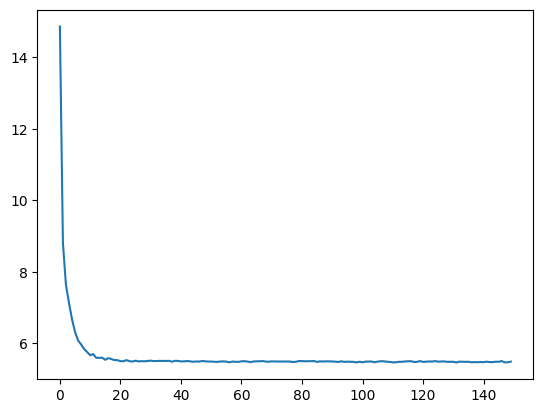

In [31]:
mean_loss = np.mean(losses, axis=1)

# calc mape



plt.plot(mean_loss)

In [32]:
model.eval()
loss_test = []
y_pred_test = []
y_true_test = []
cost = 0
for time, snapshot in enumerate(test_dataset):
     
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)

    y_pred_test.append(y_hat.detach().numpy())
    y_true_test.append(snapshot.y.detach().numpy())

    c = F.mse_loss(y_hat, snapshot.y)
    loss_test.append(c.detach().numpy())
    cost = cost + c
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 8.9945


In [33]:
print(torch.Tensor(y_pred_test).shape)
print(torch.Tensor(y_true_test).shape)

torch.Size([218, 11, 1])
torch.Size([218, 11, 1])


/var/folders/h8/mhwh4fjn0qj405sjdd9_5ffw0000gn/T/ipykernel_15856/2569780536.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  print(torch.Tensor(y_pred_test).shape)


In [34]:
# plot y_pred and y_true
y_pred_test_mean = np.array(y_pred_test).reshape(-1, node_num * time_step_out).mean(axis=1).flatten()
y_true_test_mean = np.array(y_true_test).reshape(-1, node_num * time_step_out).mean(axis=1).flatten()

print('shape: ', y_pred_test_mean.shape)
print('shape: ', y_true_test_mean.shape)

shape:  (218,)
shape:  (218,)


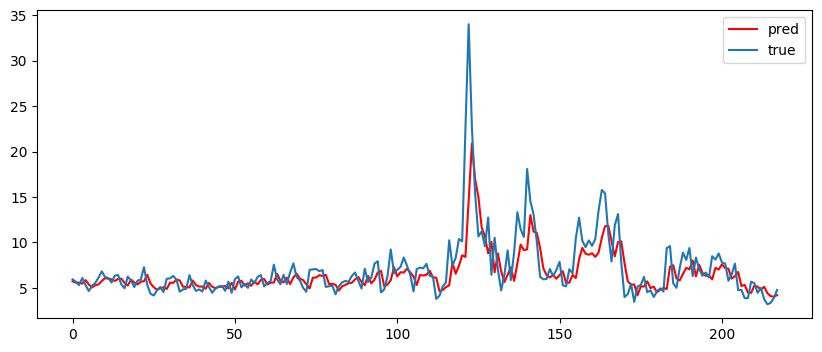

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.lineplot(data=y_pred_test_mean, label="pred", color='red')
sns.lineplot(data=y_true_test_mean, label="true")

In [36]:
# Calc MAPE
y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)


mape = np.mean(np.abs((y_true_test - y_pred_test) / y_true_test)) * 100
print("MAPE: {:.4f}".format(mape))

# Calc MAE
mae = np.mean(np.abs(y_true_test - y_pred_test))
print("MAE: {:.4f}".format(mae))

# Calc RMSE 
rmse = np.sqrt(np.mean((y_true_test - y_pred_test) ** 2))
print("RMSE: {:.4f}".format(rmse))


# Calc MSE
mse = np.mean((y_true_test - y_pred_test) ** 2)
print("MSE: {:.4f}".format(mse))

MAPE: 24.0435
MAE: 1.7246
RMSE: 2.9991
MSE: 8.9945


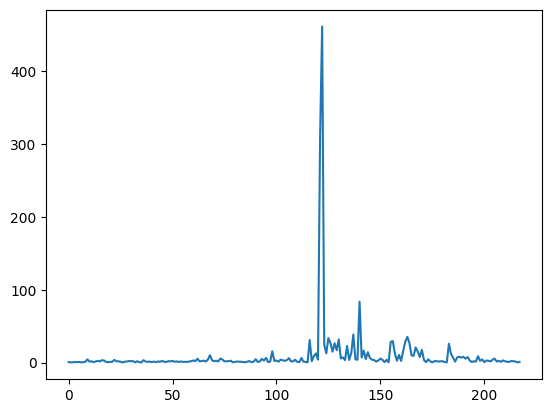

In [37]:
# plot loss
import matplotlib.pyplot as plt
plt.plot(loss_test)

In [38]:
# mean loss in each epoch
losses_mean = [np.mean(i) for i in losses]

for i in range(epoch_num):
    print(f'epoch [{i}/{epoch_num}] :', losses_mean[i])


epoch [0/150] : 14.859006395136271
epoch [1/150] : 8.801757047995242
epoch [2/150] : 7.630467909208815
epoch [3/150] : 7.129743956695866
epoch [4/150] : 6.669581106419615
epoch [5/150] : 6.315864626617265
epoch [6/150] : 6.07743823124147
epoch [7/150] : 5.965285721175167
epoch [8/150] : 5.838551138296997
epoch [9/150] : 5.753075872018181
epoch [10/150] : 5.6650441170012185
epoch [11/150] : 5.69491127476848
epoch [12/150] : 5.591054524683795
epoch [13/150] : 5.588690327437714
epoch [14/150] : 5.5939780245834125
epoch [15/150] : 5.5348986535495435
epoch [16/150] : 5.582091256339582
epoch [17/150] : 5.556553621819123
epoch [18/150] : 5.526725546901174
epoch [19/150] : 5.525536031462252
epoch [20/150] : 5.496555456225205
epoch [21/150] : 5.49428383461755
epoch [22/150] : 5.526611378407875
epoch [23/150] : 5.494847077799431
epoch [24/150] : 5.486996537339318
epoch [25/150] : 5.5102138348573115
epoch [26/150] : 5.490199187864473
epoch [27/150] : 5.49762050028241
epoch [28/150] : 5.4928913967